In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(tidyverse)
library(reshape2)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: 
Attaching package: ‘reshape2’


R[write to console]: The following object is masked from ‘package:tidyr’:

    smiths





## Random Number Generator
### Implementation of a linear congruential generator (LCG).

The RNG here presented is the _Linear Congruental Generator_ (LGC), which has the form:
$$\begin{aligned}
  x_{i}&=mod(ax_{i-1}+c, M)\\
  \text{with } U_i &= \frac{x_{i}}{M}
\end{aligned}$$

where:

- a is the multiplier
- c is the shift
- M is the modulus
- $U_{i}$ is the Uniform Random Variable in (0,1)

The function check the initial condition of non-negativity and then output the generated sequence

In [3]:
%%R
rng_lcg<-function(a,c,m,x,n){
  # check condition
  if(m<0 ||a<0 || c <0 ||x<0 || m< a || m<c || m< x){
    return("Error of the choiche of the parameters")
  }
  #check prime
  seq=c(x)
  for (i in 2:n){
    seq[i]= (a*seq[i-1]+c)%%m
  }
  return(seq/m)
}

### Generate 10.000 pseudo-random numbers and present these numbers in a histogram (e.g. 10 classes)

These LCG parameters have been suggested the ones used by the `random0` function in Matlab.

Therefore, we expect that these would perform well in our statistical tests.

In [4]:
%%R
rand_numbers_good <-
  rng_lcg(a = 8121, c = 28411, m = 134456, x = 0, n = 10000)

## Test for RNG
### Evaluate the quality of the generator by graphical descriptive statistics (histograms, scatter plots) and statistical tests (chi-squared, Kolmogorov-Smirnov, run-tests, and correlation test).

The main empirical tests are: _$\chi^2$ test_,  _Kolmogorov-Smirnov test_, _Run test_ and _Correlation test_; on top of this are also performed visual test using _histograms_ and _lag plots_

#### I. Visual tests
The histogram of the 10.000 generated pseudo-random numbers, is plotted below, with the number of bins set to 10

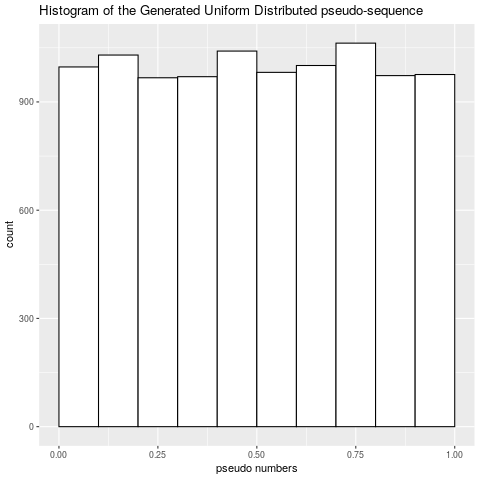

In [5]:
%%R
breaks = c(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1)
ggplot()+
  stat_bin(aes(rand_numbers_good),breaks = breaks, colour="black", fill="white")+
  ggtitle("Histogram of the Generated Uniform Distributed pseudo-sequence")+
  xlab("pseudo numbers")

The lag plot, in this case for lag=1 is:

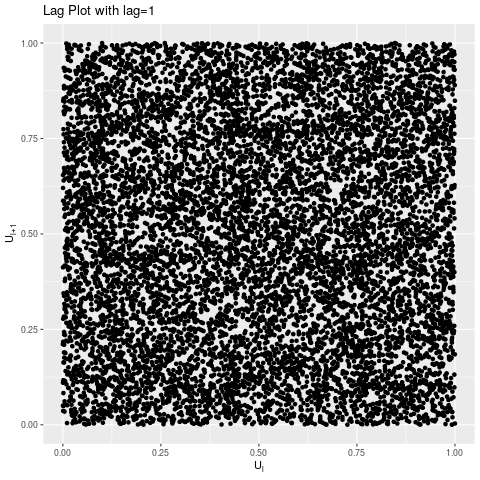

In [6]:
%%R
df<-data.frame(x=rand_numbers_good[-10000],y=rand_numbers_good[-1])
df%>%
  ggplot()+
  geom_point(aes(x=x,y=y))+
  ggtitle("Lag Plot with lag=1")+ ylab(expression(U[i+1]))+ xlab(expression(U[i]))

#### II. $\chi^2$ test
The implemented _$\chi^2$ test_ is intended to work on a Uniform Distribution, it returns the test statistics and the p-value: 

If $X$ represents any of the $X_{j}$, the the _Null-Hyphotesis_ to be tested is:
$$
H_{0}: P\{X=i\}=p_{i}, \quad i=1, \ldots, k
$$ 
where $k$ is an arbitrary number of intervals.

So the _Null-Hyphotesis_ declare that the sample is Uniformly distributed

The test statistic is in the form:
$$
T=\sum_{i=1}^{k} \frac{\left(N_{i}-n p_{i}\right)^{2}}{n p_{i}}
$$
where $N_{i}$ is the number of $X_{1}, \ldots, X_{n},$ independent random variables having mass function $p_{i}, i=1, \ldots, k$; the _Null-hypothesis_ is rejected when $T$ is large. 

If the computed test quantity $T=t$, the $p$-value is given as:
$$
p \text { -value }=P_{H_{0}}[T \geqslant t]
$$
where  $P_{H_{0}}$ is the probability computed under the assumption that $H_{0}$ is true.

$T$ has approximately a $\chi^2$ distribution with $k-1$ degrees of freedom.

In [7]:
%%R
chisquare_test<-function(pseudo_seq,n_intervals=10,power=0.05){
  pseudo_seq<-sort(pseudo_seq)
  interv<-cumsum(c(0,rep(1/n_intervals,n_intervals)))
  N<-c()
  x<-c()
  for (i in 1:(n_intervals)){
    N[i]=(sum(pseudo_seq>interv[i] & pseudo_seq<= interv[i+1]))
    x[i]=length(pseudo_seq)*(1/n_intervals)
  }
  t=sum(((N-x)**2)/x)
  p.value=pchisq(t,n_intervals-1,
                 lower.tail = FALSE)
  chi.value=qchisq(power,n_intervals-1,
                   lower.tail = FALSE)
  cat(sprintf("t-value is: %f",t),sprintf("chi-square value is: %f",chi.value),
      sprintf("p-value is: %f",p.value),sep="\n")
}

The test for the generated sequence of the implemented LCG is:

In [8]:
%%R
chisquare_test(rand_numbers_good)

t-value is: 10.185000
chi-square value is: 16.918978
p-value is: 0.335717


So there is not evidence to reject the _Null-Hypothesis_, and it is assumed that the sequence is Uniformly Distributed

#### III. Kolmogorov-Smirnov test
The _Kolmogorov-Smirnov test_ tests the _Null-Hypothesis_ $H_{0}$ that a set of indipendent Random variables have a common (known) continuous distribution function $F$.

The implementation can plot the empirical and theoretical distribution and works for both normal and uniform distribution if the parameters are known, the choiche of the level of significance is limited to 5 values.

If the computed test statistic $D\gg d$ where $d$ is the theretical test value, the _Null-Hypothesis_ is rejected.

In [9]:
%%R
Kol.smir_test<-function(pseudo_seq,plot=FALSE,family="unif",par1=0,par2=1,power=0.95){
  power.test<-c(0.85, 0.90,0.95,0.975,0.99)
  values<-c(1.138,1.224,1.358,1.480,1.628)
  pseudo_seq<-sort(pseudo_seq)
  F.e<-c(0)
  if(family=="norm"){
    F.t<-pnorm(pseudo_seq,mean = par1,sd = par2)
  }
  if(family=="unif"){
    F.t<-punif(pseudo_seq,min = par1,max = par2)
  }
  for (i in 2:length(pseudo_seq)){
    F.e[i]=(sum(I(pseudo_seq<=pseudo_seq[i])))/length(pseudo_seq)
  }
  if (plot==TRUE){
    df<-data.frame(F.e=F.e,F.t=F.t,x=pseudo_seq)
    pp<-ggplot(data=df,aes(x=x,y=F.e))+
      geom_step(colour="red")+
      geom_line(aes(y=F.t,x=x),linetype = "dashed")+
      ggtitle("ECDF vs Theoretical distribution")+
      xlab("x")+ylab("F(X)")
    print(pp)
  }
  D<-max((F.e-F.t),(F.t-F.e))
  test.value<-(sqrt(length(pseudo_seq))+0.12+(0.11/length(pseudo_seq)))*D
  if (power %in% power.test){
    ind<-match(power,power.test)
    theo.value<-values[ind]
    }
  else{
    return("Error in the choiche of the level of significance in the test")
  }
  cat(sprintf("The test-value is: %f",test.value),
      sprintf("The theoretical value is: %f",theo.value),sep="\n")
}

Now performing this test with a level of significance of 0.95 gives the following result:

In [10]:
%%R
Kol.smir_test(rand_numbers_good)

The test-value is: 0.668869
The theoretical value is: 1.358000


As we see the computed test value is smaller than the theoretical one, so there is small evidence to reject the _Null Hypothesis_, and it is assumed that the realization are uniformly distributed.


#### IV. Up/Down Run Test (from Donald Knuth)
The _Run test_ implemented here is the one proposed from Donald Knuth, and it is intended to work only with the Uniform Distribution; 

In order to correctly and properly use this test, the values for matrices A and B are precomputed, but this put a constraint for this test, in fact the computed Runs of the generated sequence of pseudo number must have a binning of 6.

In [11]:
%%R
knuth_run_test_eval <- function(rand_nr_vector, nr_bins, chi_sq_alpha) {

  R <- rep(0, nr_bins)
  n = length(rand_nr_vector)

  # If we don't have enough data to perform this test, we will alert of that
  if (n < 4000) {

    cat("There were less than 4000 samples in the given sequence,", 
        "therefore this test is not suitable for the data.",sep="\n")

  } else {
    current_run_length = 1

    for (i in 2:length(rand_nr_vector)) {
      # If the sequence is an UP sequence:
      if (rand_nr_vector[i-1] < rand_nr_vector[i]) {

        current_run_length = current_run_length + 1

      } else if (rand_nr_vector[i-1] >= rand_nr_vector[i]) {

        if (current_run_length >= nr_bins)
          R[nr_bins] = R[nr_bins] + 1
        else
          R[current_run_length] = R[current_run_length] + 1

        current_run_length = 1
      }
    }

    if (nr_bins == 6) {
      A <- matrix(
        c(4529.4, 9044.9, 13568, 18091,  22615,  27892,
          9044.9, 18097,  27139, 36187,  45234,  55789,
          13568,  27139,  40721, 54281,  67852,  83685,
          18091,  36187,  54281, 72414,  90470,  111580,
          22615,  45234,  67852, 90470,  113262, 139476,
          27892,  55789,  83685, 111580, 139476, 172860),
        nrow = 6, ncol = 6)

      # B has 1 row and 6 columns (opposite to the literature) 
      # because those are also the dimensions of our R vector
      B <- matrix(
        c(1/6,
          5/24,
          11/120,
          19/720,
          29/5040,
          1/840),
        nrow = 1, ncol = 6)

      # Z is our test statistic, which we must compare against a 
      #chi_squared distribution
      Z <- (1 / (n - nr_bins)) * ((R - n * B) %*% A %*% t(R - n * B))

      chi_squared_quantile <- qchisq(p = chi_sq_alpha, df = nr_bins)

      if (Z >= chi_squared_quantile)

        cat("Rejected the NULL hypothesis, since Z >> chi-squared test value.", 
               "Therefore, the given sample does not have independence between the 
               elements of the sequence.",sep="\n")

      else #(Z < chi_squared_quantile)

        cat("The value of Z is smaller than the chi-squared test value.", 
               "Therefore, we fail to reject the NULL hypothesis,",
            "and will assume that sequence has mutually independent numbers.",sep = "\n")
      
    } else {

      cat("We have not yet prepared the matrices A and B for the", 
             "specified number of bins of a run.",sep = "\n")

    }
  }
}

Let us now check for independence of the LCG sample using this run test:

In [12]:
%%R
knuth_run_test_eval(rand_numbers_good, nr_bins = 6, chi_sq_alpha = 0.95)

The value of Z is smaller than the chi-squared test value.
Therefore, we fail to reject the NULL hypothesis,
and will assume that sequence has mutually independent numbers.


The result of the test tells us that Z < chi_squared_quantile, therefore the _Null Hypothesis_ fails to be rejected and we can assume independence between the numbers given by the LCG

#### V. Correlation test
The _Correlation test_ implemented compute and output the value

$$
c_{h}=\frac{1}{n-h} \sum_{i=1}^{n-h} U_{i} U_{i+h}
$$
with an arbitrary value of $h$, as $c_{h}\sim \mathrm{N}\left(0.25, \frac{7}{144 n}\right)$, the user is notified that the expected value is 0.25; A large value is a sign of dependence/correlation of the generated sequence.

In [13]:
%%R
corr.test<-function(pseudo_seq,lag=1){
  n<-length(pseudo_seq)
  c<-0
  for(i in 1:(n-lag)){
    c<-c+(pseudo_seq[i]*pseudo_seq[i+lag])
  }
  c<-(1/(n-lag))*c
  cat(sprintf("The theretical expected value is 0.25"),
      sprintf("The computed coefficient of correlation at lag %d is %f",lag, c),sep = "\n")
}

corr.test(pseudo_seq = rand_numbers_good,lag=3)

The theretical expected value is 0.25
The computed coefficient of correlation at lag 3 is 0.249203


This is a confirmation of the preceding test, and the implemented LCG is a valid RNG.

### Experimenting with different values of “a”, “M” and “c”.

The validity of the RNG can be tested as done before, but one characteristic of a "good" RNG is its _cycle lenght_: to obtain a _full period_ (cycle lenght equal to n) there are 3 main condition:

1. The only positive integer that (exactly) divides both $m$ and $c$ is 1 ($c$ is relatively prime to $m$).
2. If $q$ is a prime number that divides $m$, then $q$ divides $a-1$
3. If 4 divides $m$, then 4 divides $a-1$

The generator that we have used in 1a. seems to be a good generator (from the results of our previous tests) and we will keep it as our final generator, using the parameter values selected in 1a.
 
Here in this subpart, we will try to give an example of a bad selection of parameters which leads to a bad generator, and subsequently show the results of the previous statistical tests upon this bad sequence of pseudonumbers.

These LCG parameters have been chosen from example in the Stochastic Simulation slides (L1.3 Slide 15)

In [14]:
%%R
rand_numbers_bad <- rng_lcg(a = 5, c = 1, m = 16, x = 0, n = 10000)

Histogram presentation of the pseudorandom numbers selected:

The histogram of the 10.000 generated pseudo-random numbers, is plotted below, with the number of bins set to 10

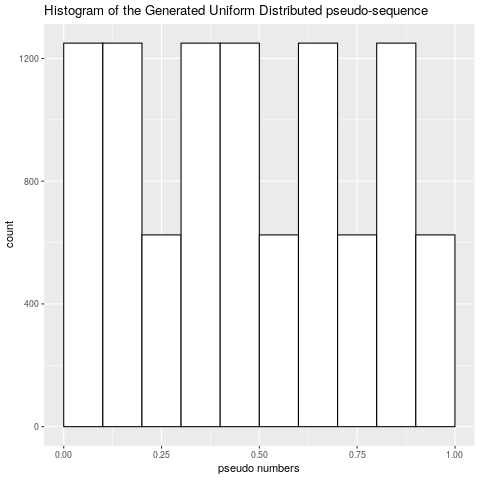

In [15]:
%%R
breaks = c(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1)
ggplot()+
  stat_bin(aes(rand_numbers_bad),breaks = breaks, colour="black", fill="white")+
  ggtitle("Histogram of the Generated Uniform Distributed pseudo-sequence")+
  xlab("pseudo numbers")

#### I. Visual tests
 
Scatterplot test for quick verification of obvious non-independence issues between consequent sequence numbers

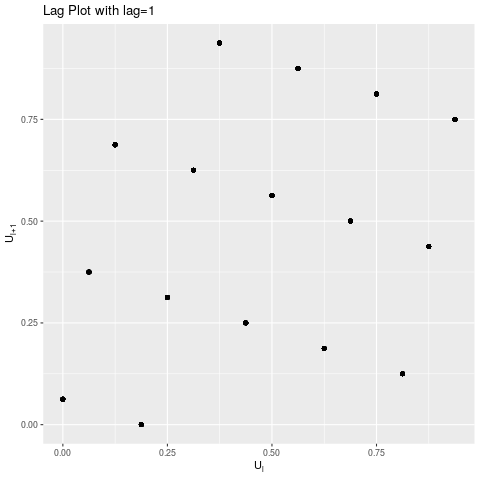

In [16]:
%%R
df<-data.frame(x=rand_numbers_bad[-10000],y=rand_numbers_bad[-1])
df%>%
  ggplot()+
  geom_point(aes(x=x,y=y))+
  ggtitle("Lag Plot with lag=1")+ ylab(expression(U[i+1]))+ xlab(expression(U[i]))

The scatterplot shows clearly, without doubt, that the realization of our random variables gives non-independent samples from the RNG. Therefore, there is an issue with the parameters selected for this LCG (of course, in this particular situation, this is exactly what we try to achieve)

#### II. Chi-squared test (for distribution type)

In [17]:
%%R
chisquare_test(rand_numbers_bad)

t-value is: 1015.625000
chi-square value is: 16.918978
p-value is: 0.000000


It seems that the $\chi^2$-test also quickly demonstrates that the given distribution is not uniform.

#### III. Kolmogorov-Smirnov test

In [18]:
%%R
Kol.smir_test(rand_numbers_bad)

The test-value is: 6.257501
The theoretical value is: 1.358000


The $D$ value(test-value) is large and greater than the theoretical value, the pseudo-sequence is not uniformly distributed.

#### IV. Up/Down Run Test (from Donald Knuth)

In [19]:
%%R
knuth_run_test_eval(rand_numbers_bad, nr_bins = 6, chi_sq_alpha = 0.95)

Rejected the NULL hypothesis, since Z >> chi-squared test value.
Therefore, the given sample does not have independence between the 
               elements of the sequence.


The results of the test clearly reject the _Null Hypothesis_ of independence between the samples, which has been the same conclusion found as early as from the visual test.

#### V. Correlation test

In [20]:
%%R
corr.test(rand_numbers_bad)

The theretical expected value is 0.25
The computed coefficient of correlation at lag 1 is 0.242212


This test doesn't show an high correlation between the samples at lag=1.

### Apply a system-available generator and perform the various statistical tests

The R function 'runif()', shortened for "Random Uniform sampler", will use a Mersenne Twister, which is the state-of-the-art in terms of pseudorandom number generation

In [21]:
%%R
rand_numbers_R <- runif(10000)

Let us perform an evaluation of the distribution and independence upon this RNG as well:

#### I. Visual tests

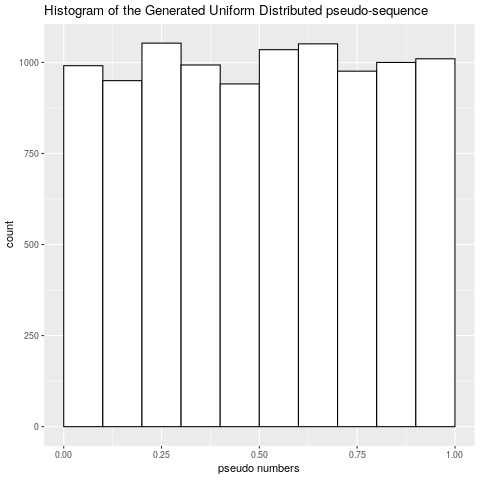

In [22]:
%%R
breaks = c(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1)
ggplot()+
  stat_bin(aes(rand_numbers_R),breaks = breaks, colour="black", fill="white")+
  ggtitle("Histogram of the Generated Uniform Distributed pseudo-sequence")+
  xlab("pseudo numbers")

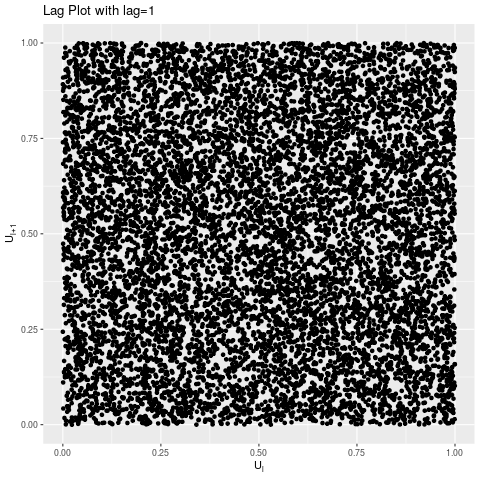

In [23]:
%%R
df<-data.frame(x=rand_numbers_R[-10000],y=rand_numbers_R[-1])
df%>%
  ggplot()+
  geom_point(aes(x=x,y=y))+
  ggtitle("Lag Plot with lag=1")+ ylab(expression(U[i+1]))+ xlab(expression(U[i]))

The visual plots look good.

#### II. Chi-squared test (for distribution type)

In [24]:
%%R
chisquare_test(rand_numbers_R)

t-value is: 13.422000
chi-square value is: 16.918978
p-value is: 0.144422


The chi_squared test determines that these numbers were sampled from a uniform distribution.

#### III. Kolmogorov-Smirnov test

In [25]:
%%R
Kol.smir_test(rand_numbers_R)

The test-value is: 0.742456
The theoretical value is: 1.358000


The Kolmogorov-Smirnov test shows a value of D which is very small, thus hinting towards the same result as the chi-squared test

#### IV. Up/Down Run Test (from Donald Knuth)

In [26]:
%%R
knuth_run_test_eval(rand_numbers_R, nr_bins = 6, chi_sq_alpha = 0.95)

Rejected the NULL hypothesis, since Z >> chi-squared test value.
Therefore, the given sample does not have independence between the 
               elements of the sequence.


The Knuth run test shows that the consequent samples seem to have mutual independence (because we failed to reject the _Null Hypothesis_).

#### V. Correlation test

In [27]:
%%R
corr.test(rand_numbers_R)

The theretical expected value is 0.25
The computed coefficient of correlation at lag 1 is 0.250515


This test again doesn't show high correlation between the samples at lag=1.

All of these above results fall in line with what we would want and expect from a state-of-the-art RNG.

## Simulation of Discrete Variables

The goal is to generate a sequence with an arbitrary distribution, starting from a generated Uniform Distributed sequence; in this case the focus is on Discrete Variables.

### Geometric distribution

For this part the _Geometric Distribution_ is generated using the formula
$$
X=\left\lfloor\frac{\log (U)}{\log (q)}\right\rfloor+1
$$
where $q=1-p$.

The first run is performed with $p$=0.1, the second with $p$=0.5 and the third with $p$=0.95;

In [28]:
%%R

set.seed(1)
U <- runif(10000)
p1 <- 0.1;p2<-0.5;p3<-0.95
x1 <- floor(log(U) / log(1-p1)) + 1
x2 <- floor(log(U) / log(1-p2)) + 1
x3 <- floor(log(U) / log(1-p3)) + 1

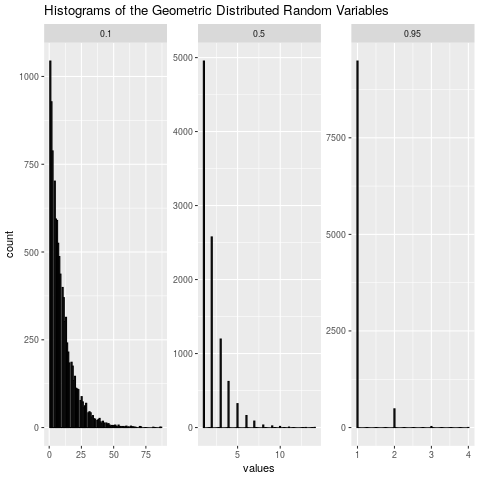

In [29]:
%%R
p_factor<-c(rep(p1,length(x1)),rep(p2,length(x2)),
                rep(p3,length(x3)))
df<-data.frame("values"=c(x1,x2,x3),"factor"=p_factor)
df%>%ggplot()+
  geom_histogram(aes(x=values),bins = 100,fill="white", color="black")+
  ggtitle("Histograms of the Geometric Distributed Random Variables")+
  facet_wrap(vars(factor), scales="free")

The generated sequence have a narrow interval with a large value of $p$: with $p$=0.95 values are in range [1,4], instead with $p$=0.1, the value are in range [1,87]


## Simulation of Continuous Variables

The goal is to generate a sequence with an arbitrary distribution, starting from a generated Uniform Distributed sequence; in this case the focus is on Continuous Variables.

### Exponential distribution
An exponential random variable $X$ with rate $\lambda(\operatorname{mean} 1 / \lambda)$ can be generated by generating a random variable $U$ and setting both the formula:
$$
\begin{aligned}
X&=-\frac{1}{\lambda} \log (1-U)\\
X&=-\frac{1}{\lambda} \log (U)\\
\end{aligned}
$$
because if $U$ is Uniformely Distributed $U$.

But in this $\lambda$ is set to 1:

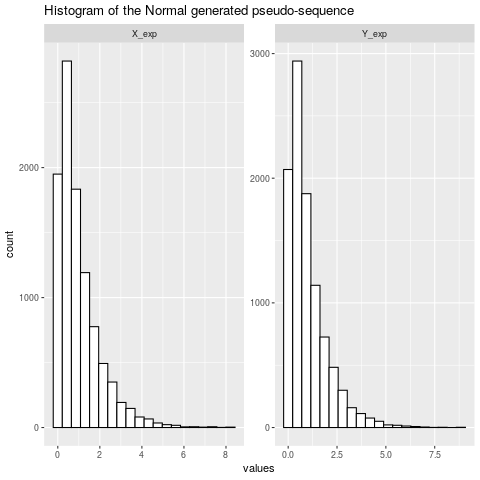

In [30]:
%%R
U<-runif(10000)
X_exp <- -log(U)
Y_exp <- -log(1-U)

df<-data.frame("values"=c(X_exp,Y_exp), 
               "factors"=c(rep("X_exp",length(X_exp)),rep("Y_exp",length(Y_exp))))
df%>%ggplot()+
  geom_histogram(aes(x=values),bins=20,colour="black", fill="white")+
  ggtitle("Histogram of the Normal generated pseudo-sequence")+
  facet_wrap(vars(factors),scales = "free")

It is possible also to test with _Kolmogorov-Smirnov test_:

In [31]:
%%R
ks.test(X_exp,rexp(length(X_exp)))


	Two-sample Kolmogorov-Smirnov test

data:  X_exp and rexp(length(X_exp))
D = 0.01, p-value = 0.6994
alternative hypothesis: two-sided



So the _Null-Hyphotesis_ cannot be rejected and it is assumed that the two samples are from the same distribution.


### Normal distribution with standard Box-Mueller

For the generation of a normally distributed Random Variable the _Box-Mueller Method_ is used: considering $X$ and $Y$ as independent standard normal random variables,  $R$ and $\Theta$ denote the polar coordinates of the vector $(X, Y)$:
$$
\begin{aligned}
R^{2} &=X^{2}+Y^{2} \\
\tan \Theta &=\frac{Y}{X}
\end{aligned}
$$ 
with $R^{2}$ and $\Theta$ independent, $R^{2}$ is exponentially distributed (mean equal to 2) and $\Theta$ is uniformly distributed in $(0,2 \pi)$

$X$ and $Y$ can be generated as follows:
$$
 \begin{array}{l}
 X=R \cos \Theta=\sqrt{-2 \log U_{1}} \cos \left(2 \pi U_{2}\right) \\
 Y=R \sin \Theta=\sqrt{-2 \log U_{1}} \sin \left(2 \pi U_{2}\right)
 \end{array}
$$

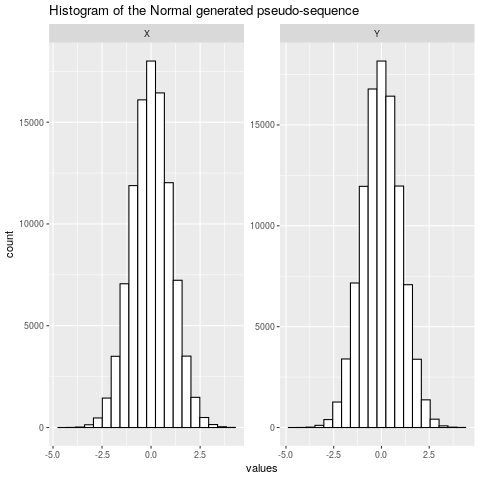

In [32]:
%%R
set.seed(NULL)
U1 <- runif(100000)
U2 <- runif(100000)
X <- sqrt(-2*log(U1))*cos(2*pi*U2)
Y <- sqrt(-2*log(U1))*sin(2*pi*U2)

df<-data.frame("values"=c(X,Y), "factors"=c(rep("X",length(X)),rep("Y",length(Y))))
df%>%ggplot()+
  geom_histogram(aes(x=values),bins=20,colour="black", fill="white")+
  ggtitle("Histogram of the Normal generated pseudo-sequence")+
  facet_wrap(vars(factors),scales = "free")

For this distribution it is possible to run the _Kolmogorov-Smirnov test_

In [33]:
%%R
ks.test(X,y = rnorm(length(X)))


	Two-sample Kolmogorov-Smirnov test

data:  X and rnorm(length(X))
D = 0.00652, p-value = 0.0285
alternative hypothesis: two-sided



It is possible to conclude that the generated Random Variable is normally distributed.

### Pareto distribution, with $\beta=1$ and experiment with different values of $k$ values: $k=2.05, k=2.5, k=3$ and $k=4$

A Pareto Random variables is definde as $X \sim Pa(k, \beta)$ and its distribution is in the form $F(x)=1-\left(\frac{\beta}{x}\right)^{k}$ with $x \geq \beta$ 

The Theoretical parameters, mean and variance are:
$$
\begin{aligned}
    E (X)&=\frac{k}{k-1} \beta\\
    \operatorname{Var}(X)&=\frac{k}{(k-1)^{2}(k-2)} \beta^{2} \quad k>1,2 
\end{aligned}
$$
and the generation, for $X \geq 0$ is based on the following equation:
$$
\begin{aligned}
X&=\beta\left(1-U\right)^{-\frac{1}{k}}
\end{aligned}
$$
So the generated Random variables for different values of $k$:

In [34]:
%%R
beta <- 1; k1 <- 2.05; k2 <- 2.5; k3 <- 3; k4 <- 4

X1 <- beta*(1-U)^(-1/k1)
X2 <- beta*(1-U)^(-1/k2)
X3 <- beta*(1-U)^(-1/k3)
X4 <- beta*(1-U)^(-1/k4)

The visualization is done with a histogram with the number of bins set to 100 to have a better result:

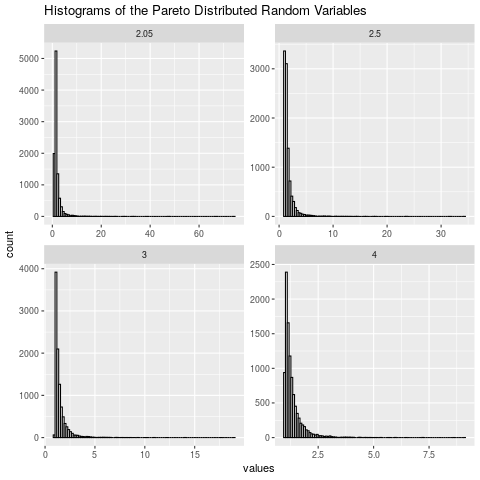

In [35]:
%%R
k_factor<-c(rep(k1,length(X1)),rep(k2,length(X2)),
                rep(k3,length(X3)),rep(k4,length(X4)))
df<-data.frame("values"=c(X1,X2,X3,X4),"factor"=k_factor)
df%>%ggplot()+
  geom_histogram(aes(x=values),bins = 100,fill="white", color="black")+
  ggtitle("Histograms of the Pareto Distributed Random Variables")+
  facet_wrap(vars(factor), scales="free")

#### Comparing mean value and variance, with analytical results.

The implementation is as follows:

In [36]:
%%R
k_list<-c(k1,k2,k3,k4)
gen_list<-list(X1,X2,X3,X4)
Th_mean<-rep(0,length(k_list))
Th_var=Emp_mean=Emp_var=Th_mean

for(i in 1:length(k_list)){
  Th_mean[i]<-beta*(k_list[i]/(k_list[i]-1))
  Th_var[i]<-(beta^2)*(k_list[i]/((k_list[i]-1)^2*(k_list[i]-2)))
  Emp_mean[i]<-mean(gen_list[[i]])
  Emp_var[i]<-var(gen_list[[i]])
}

The results are printed below:

As possible to see the Empirical mean is smaller than the Theoretical mean for a value of 1, instead the Empirical Variance is accurate and close to the Theoretical one for the larger values of $k$.

In general for $k$ small the mean is small but the variance is large, for large values of $k$ the opposite is true.

### Generation of 100 95% confidence intervals for the mean and variance of the Normal distribution, each based on 10 observations.

Fot the mean the confidence interval is:
$$
\mu-t_{\alpha/2} \frac{s}{\sqrt{n}}\leq \mu \leq\mu +t_{\alpha/2} \frac{s}{\sqrt{n}}
$$

For the variance the confidence interval is:
$$
\frac{(n-1) s^{2}}{\chi_{\alpha / 2}^{2}} \leq \sigma^{2} \leq \frac{(n-1) s^{2}}{\chi_{1-\alpha / 2}^{2}}
$$
The implementation for the mean is done using a built-in function "t-test":

In [37]:
%%R
sample_norm<-matrix(replicate(sample(Y,10,replace = TRUE),n=100),10)
mean_conf_int<-function(x,power=0.95){
  t.test(x,conf.level = power)$conf.int
  }
var_conf_int<-function(x,power=0.95){
  df<-length(x)-1
  lower_b<-qchisq((1-power)/2, df, lower.tail = TRUE)
  upper_b<-qchisq((1 - power)/2, df, lower.tail = FALSE)
  s2<-var(x)
  c(df * s2/lower_b, df * s2/upper_b)
}
conf_int_mean<-apply(sample_norm, 2, mean_conf_int)
conf_int_var<-apply(sample_norm, 2, var_conf_int)

Plotting the results of the confidence interval:

R[write to console]: Using factors as id variables



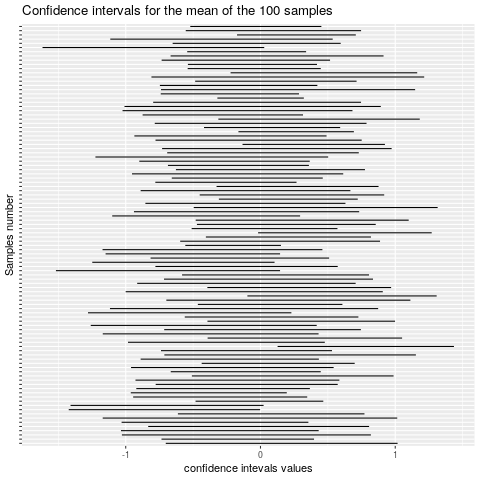

In [38]:
%%R
df_mean_int<-data.frame("mean_lower"=conf_int_mean[1,],"mean_upper"=conf_int_mean[2,],
               "factors"=as.factor(c(1:100)))
df_var_int<-data.frame("var_lower"=conf_int_var[1,],"var_upper"=conf_int_var[2,],
               "factors"=as.factor(c(1:100)))

df<-melt(df_mean_int)
ggplot(data = df, aes(y=factors,x=value))+
  geom_line()+ theme(axis.text.y = element_blank())+
  ylab("Samples number")+
  xlab("confidence intevals values")+
  ggtitle("Confidence intervals for the mean of the 100 samples")

R[write to console]: Using factors as id variables



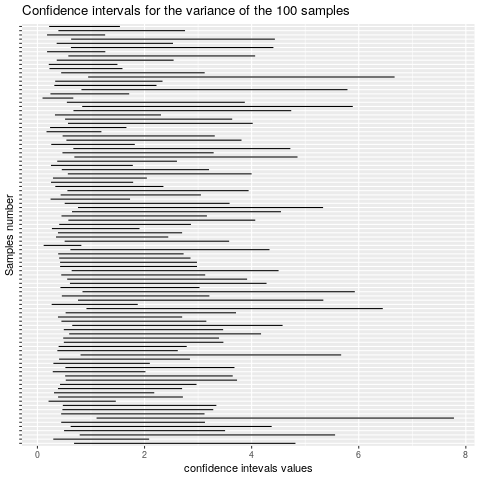

In [39]:
%%R
df<-melt(df_var_int)
ggplot(data = df, aes(y=factors,x=value))+
  geom_line()+ theme(axis.text.y =element_blank())+
  ylab("Samples number")+
  xlab("confidence intevals values")+
  ggtitle("Confidence intervals for the variance of the 100 samples")